In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from sklearn import linear_model

df=pd.read_excel("Complete-dataset-FINAL.xlsx")

### Note
Dit model is een alternatief voor de lineare regressie model. De bunsiness & data understanding zijn te vinden in de Jupyter notebook van de lineare regressie

# Data preparation

In [20]:
manufacturers = df.groupby("Manufacturer")
manufacturers.size().nlargest(20)

Manufacturer
Siemens                      991
Bio-Rad                      788
Roche Diagnostics            674
Beckman Coulter              384
Tosoh                        349
Abbott                       310
Sebia                        203
Trinity Biotech              188
Vitros                       164
Alere                        121
Arkray                        95
Axis-Shield                   57
Menarini                      52
Primus                        42
Roche Diagnostics/Hitachi     42
Bayer                         36
Metrika                       30
Olympus                       30
Synchron                      24
Not specified                 20
dtype: int64

In [21]:
df.columns = df.columns.str.replace('Total Error', 'Total')
df.columns

Index(['Method name', 'N (no. labs)', 'Mean', 'Bias', 'CV', 'Sample',
       'Reference Value', 'Year', 'Source (CAP/EurA1c)', 'Type (Fresh/frozen)',
       'Manufacturer', 'Total'],
      dtype='object')

In [22]:
list_top10 = df['Manufacturer'].value_counts()[:10].index.tolist()
top10_manufacturers = df.loc[df['Manufacturer'].isin(list_top10)]
top10_manufacturers['Manufacturer'].value_counts()
top10_manufacturers = top10_manufacturers.dropna()

In [23]:
top10_manufacturers=top10_manufacturers[['Manufacturer', 'Total', 'Year']]
top10_manufacturers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3737 entries, 0 to 4683
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Manufacturer  3737 non-null   object 
 1   Total         3737 non-null   float64
 2   Year          3737 non-null   float64
dtypes: float64(2), object(1)
memory usage: 116.8+ KB


<AxesSubplot:xlabel='Year', ylabel='Total'>

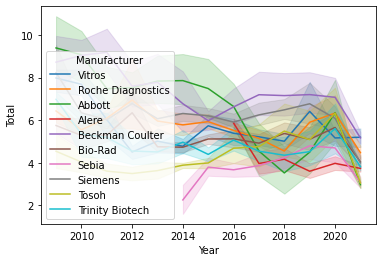

In [24]:
sns.lineplot(x="Year", y="Total",
             hue="Manufacturer", 
             data=top10_manufacturers)

# Modeling

#model regressie trainen en testen
#R2 zegt iets over de bruikbaarheid van je model
traindata, testdata = train_test_split(Siemens, train_size=0.65, test_size=0.35, random_state=42)

#eerst afhankelijke variabele, dus hierbij 'Manufacturer'
mod1 = ols(formula='Year ~ Total', data=traindata).fit()
print(mod1.summary())

In [25]:
# traindata, testdata = train_test_split(df, train_size=0.65, test_size=0.35, random_state=42)
df=df.dropna()
X_train, X_test, Y_train, Y_test = train_test_split(df["Year"].values, df["Manufacturer"].values, test_size = .20, random_state = 40)


P-value:  0.29105796634827763
P-value:  0.0003783913537194656
P-value:  0.016450142108014498


C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.w

P-value:  1.4889943958397245e-05
P-value:  0.12060619421691199


C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


P-value:  0.0002908962840627729


C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


P-value:  1.9924218254857917e-13
P-value:  0.0033321175434350967


C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


P-value:  0.028639140207967564
P-value:  2.945705182878482e-05


C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


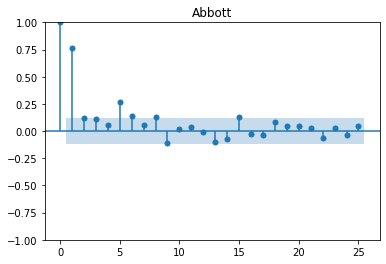

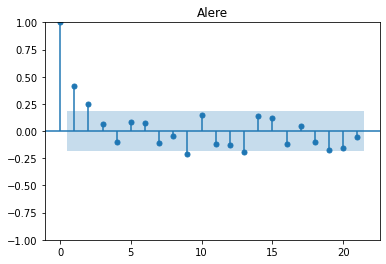

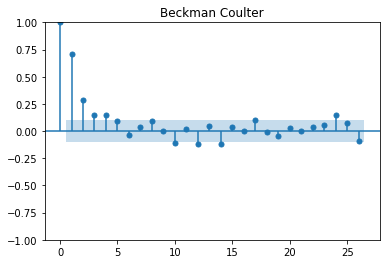

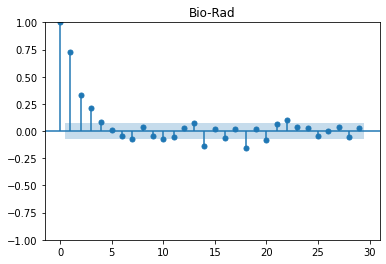

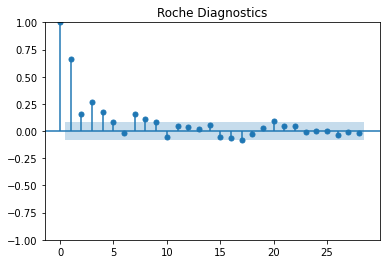

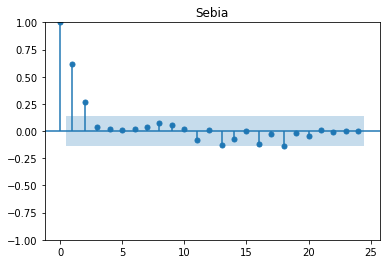

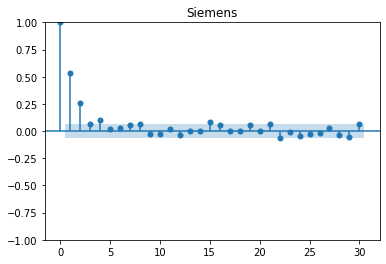

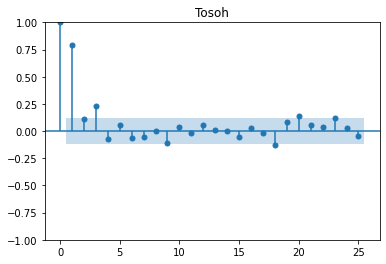

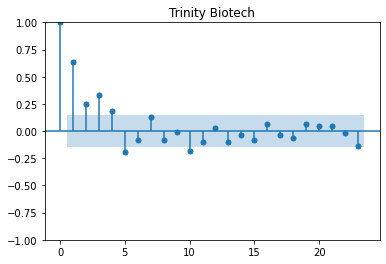

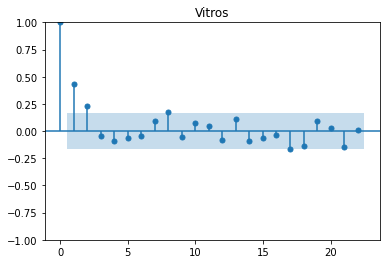

In [26]:
#
# Check for stationarity of the time-series data
# We will look for p-value. In case, p-value is less than 0.05, the time series
# data can said to have stationarity
#
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
manufacturers = top10_manufacturers.groupby("Manufacturer")

for name, data in manufacturers:
    
    df_stationarityTest = adfuller(data['Total'], autolag='AIC')
    # Check the value of p
    print("P-value: ", df_stationarityTest[1])
    pacf = plot_pacf(data['Total'], title=name)

In [27]:
from statsmodels.tsa.ar_model import AutoReg
# Create training and test data
for name, data in manufacturers:
    train_data = data['Total'][:len(df)-100]
    test_data = data['Total'][len(df)-100:]
    #
    # Instantiate and fit the AR model with training data
    #
    ar_model = AutoReg(train_data, lags=1).fit()
    #
    # Print Summary
    #
    print(ar_model.summary())
    

                            AutoReg Model Results                             
Dep. Variable:                  Total   No. Observations:                  278
Model:                     AutoReg(1)   Log Likelihood                -654.749
Method:               Conditional MLE   S.D. of innovations              2.572
Date:                Sat, 21 May 2022   AIC                           1315.499
Time:                        08:17:20   BIC                           1326.371
Sample:                             1   HQIC                          1319.861
                                  278                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4144      0.277      5.106      0.000       0.872       1.957
Total.L1       0.7597      0.039     19.725      0.000       0.684       0.835
                                    Roots           

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: Val

In [28]:
# for name, data in manufacturers:
#     tempdf = df[['Year', 'Total']].dropna()

#     X = tempdf.iloc[:, :-1].values
#     Y = tempdf.iloc[:, 1].values

#     from sklearn.model_selection import train_test_split
#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

#     from sklearn.linear_model import LinearRegression
#     regressor = LinearRegression()
#     regressor.fit(X_train, Y_train)

#     print(regressor.intercept_)
#     from matplotlib import pyplot

    
# for name, data in manufacturers:
#     # line plot for Total Error with seaborn
#     # if name == "Abbott":
#         # sns.set(rc = {'figure.figsize':(25,8)})
#         # l = sns.lineplot(x='Year', y='Total Error', data=data)
#         # sns.lineplot(x='Year', y={regressor.intercept_}, data=data)
#         # l.set_title(name)
#         # plt.show()
#         pyplot.plot('Year','Total Error',data=tempdf, color='red')
#         pyplot.plot('Year','Total Error', data=regressor.intercept_)

# Arima model

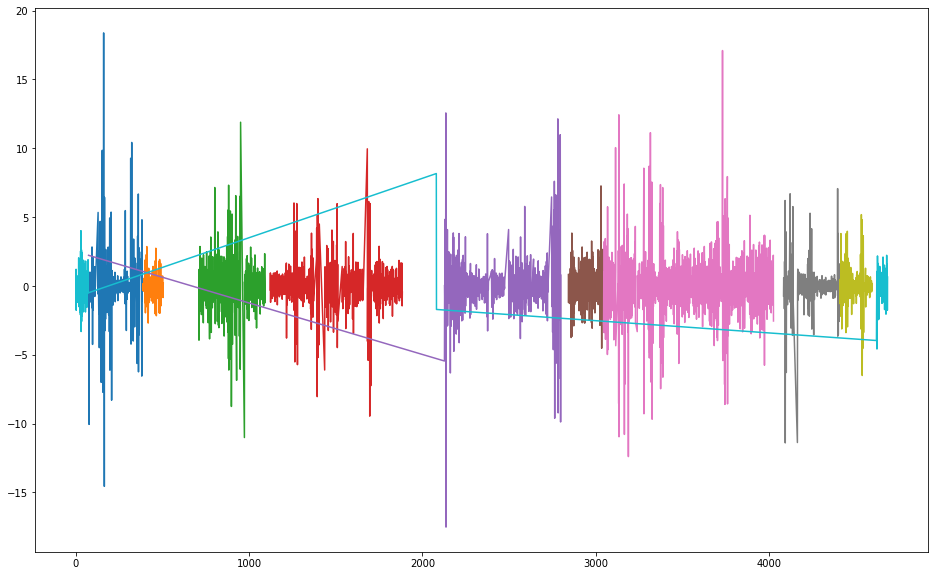

In [29]:
for name, data in manufacturers:
    data['Total'].diff().plot(figsize=(16,10))

In [30]:
for name, data in manufacturers:
    data_diff = data.diff()
    data_diff["Total"].plot()

    #Iets met float?

TypeError: unsupported operand type(s) for -: 'str' and 'str'